In [1]:
import pptk
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Test on Random Data

In [45]:
points=torch.randn([1000, 3]).numpy()
color = torch.randn([1000, 3])
color = color - color.min()
print(color.min(), color.max())
color = color / color.max() / 1.001
color = color.numpy()
color.max()

tensor(0.) tensor(6.8154)


0.99900097

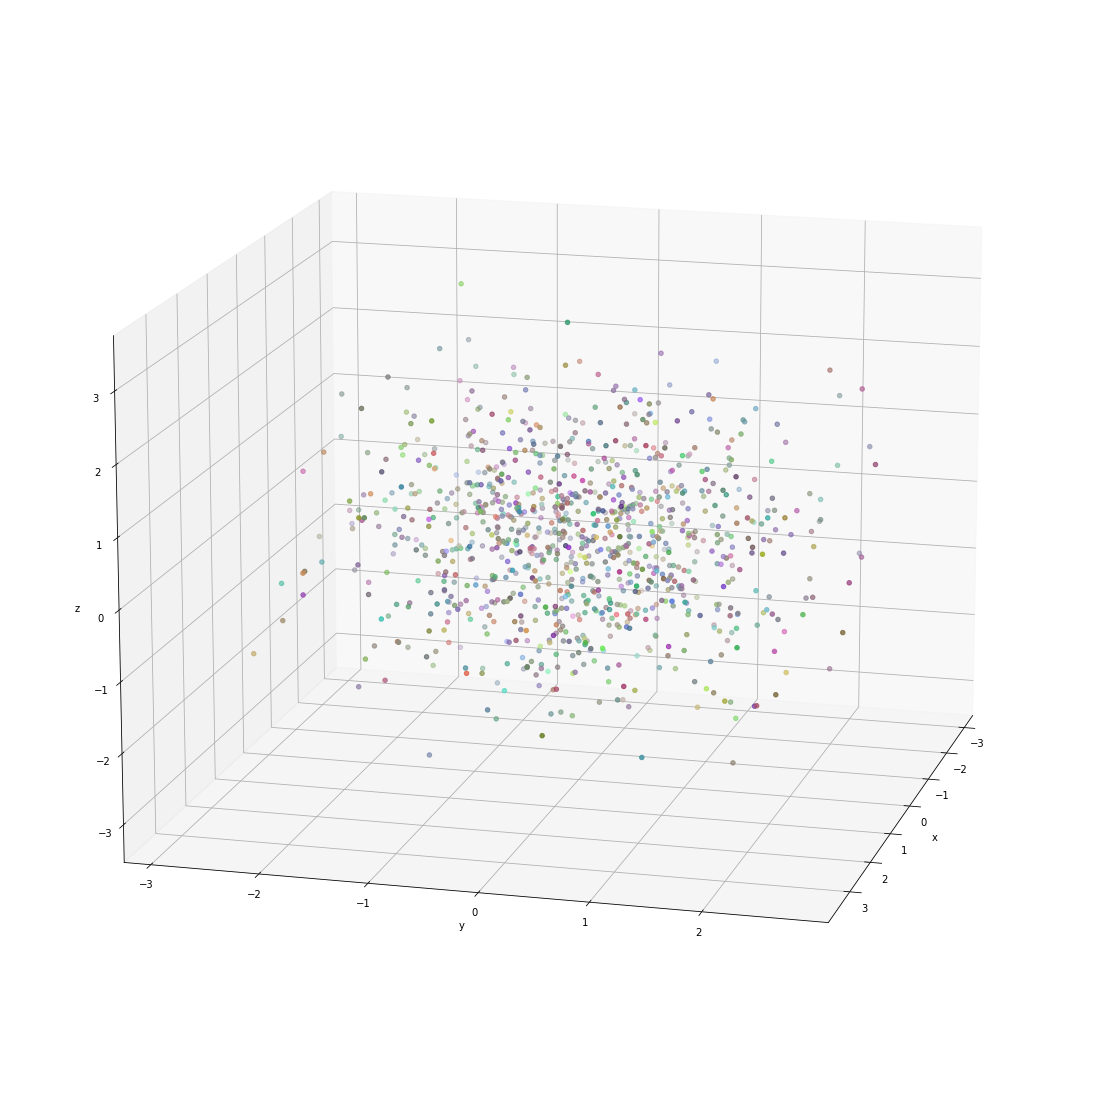

In [50]:
skip = 1  # Skip every n points

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
point_range = range(0, points.shape[0], skip) # skip points to prevent crash
ax.scatter(points[point_range, 0],   # x
           points[point_range, 1],   # y
           points[point_range, 2],   # z
           facecolors=color, # height data for color
           cmap='Spectral',
           marker="o")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.axis('auto')  # {equal, scaled}
ax.view_init(15, 15)
plt.show()

# 2. Read & Render Local Mesh

In [4]:
ply_path="/data/pkurei/mpeg/dataset/longdress/Ply/longdress_vox10_1051.ply"

In [5]:
import sys, os, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [6]:
from mpeg_process import read_mesh

In [7]:
mesh = read_mesh(ply_path)

Loading PLY file /data/pkurei/mpeg/dataset/longdress/Ply/longdress_vox10_1051.ply
Containing 765821 points


In [51]:
color, pos = mesh.color.numpy(), mesh.pos.numpy()

In [52]:
from mpl_toolkits.mplot3d import proj3d
import matplotlib as mpl
#Make sure these are floating point values:                                                                                                                                                                                              
x_scale = pos[:, 0].max()
y_scale = pos[:, 1].max()
z_scale = pos[:, 2].max()

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0
print(scale)

mpl.rcParams['legend.fontsize'] = 10

def get_subplot_proj(ax):
    def short_proj():
        return np.dot(Axes3D.get_proj(ax), scale)

    return short_proj

[[0.45355731 0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.31422925 0.        ]
 [0.         0.         0.         1.        ]]


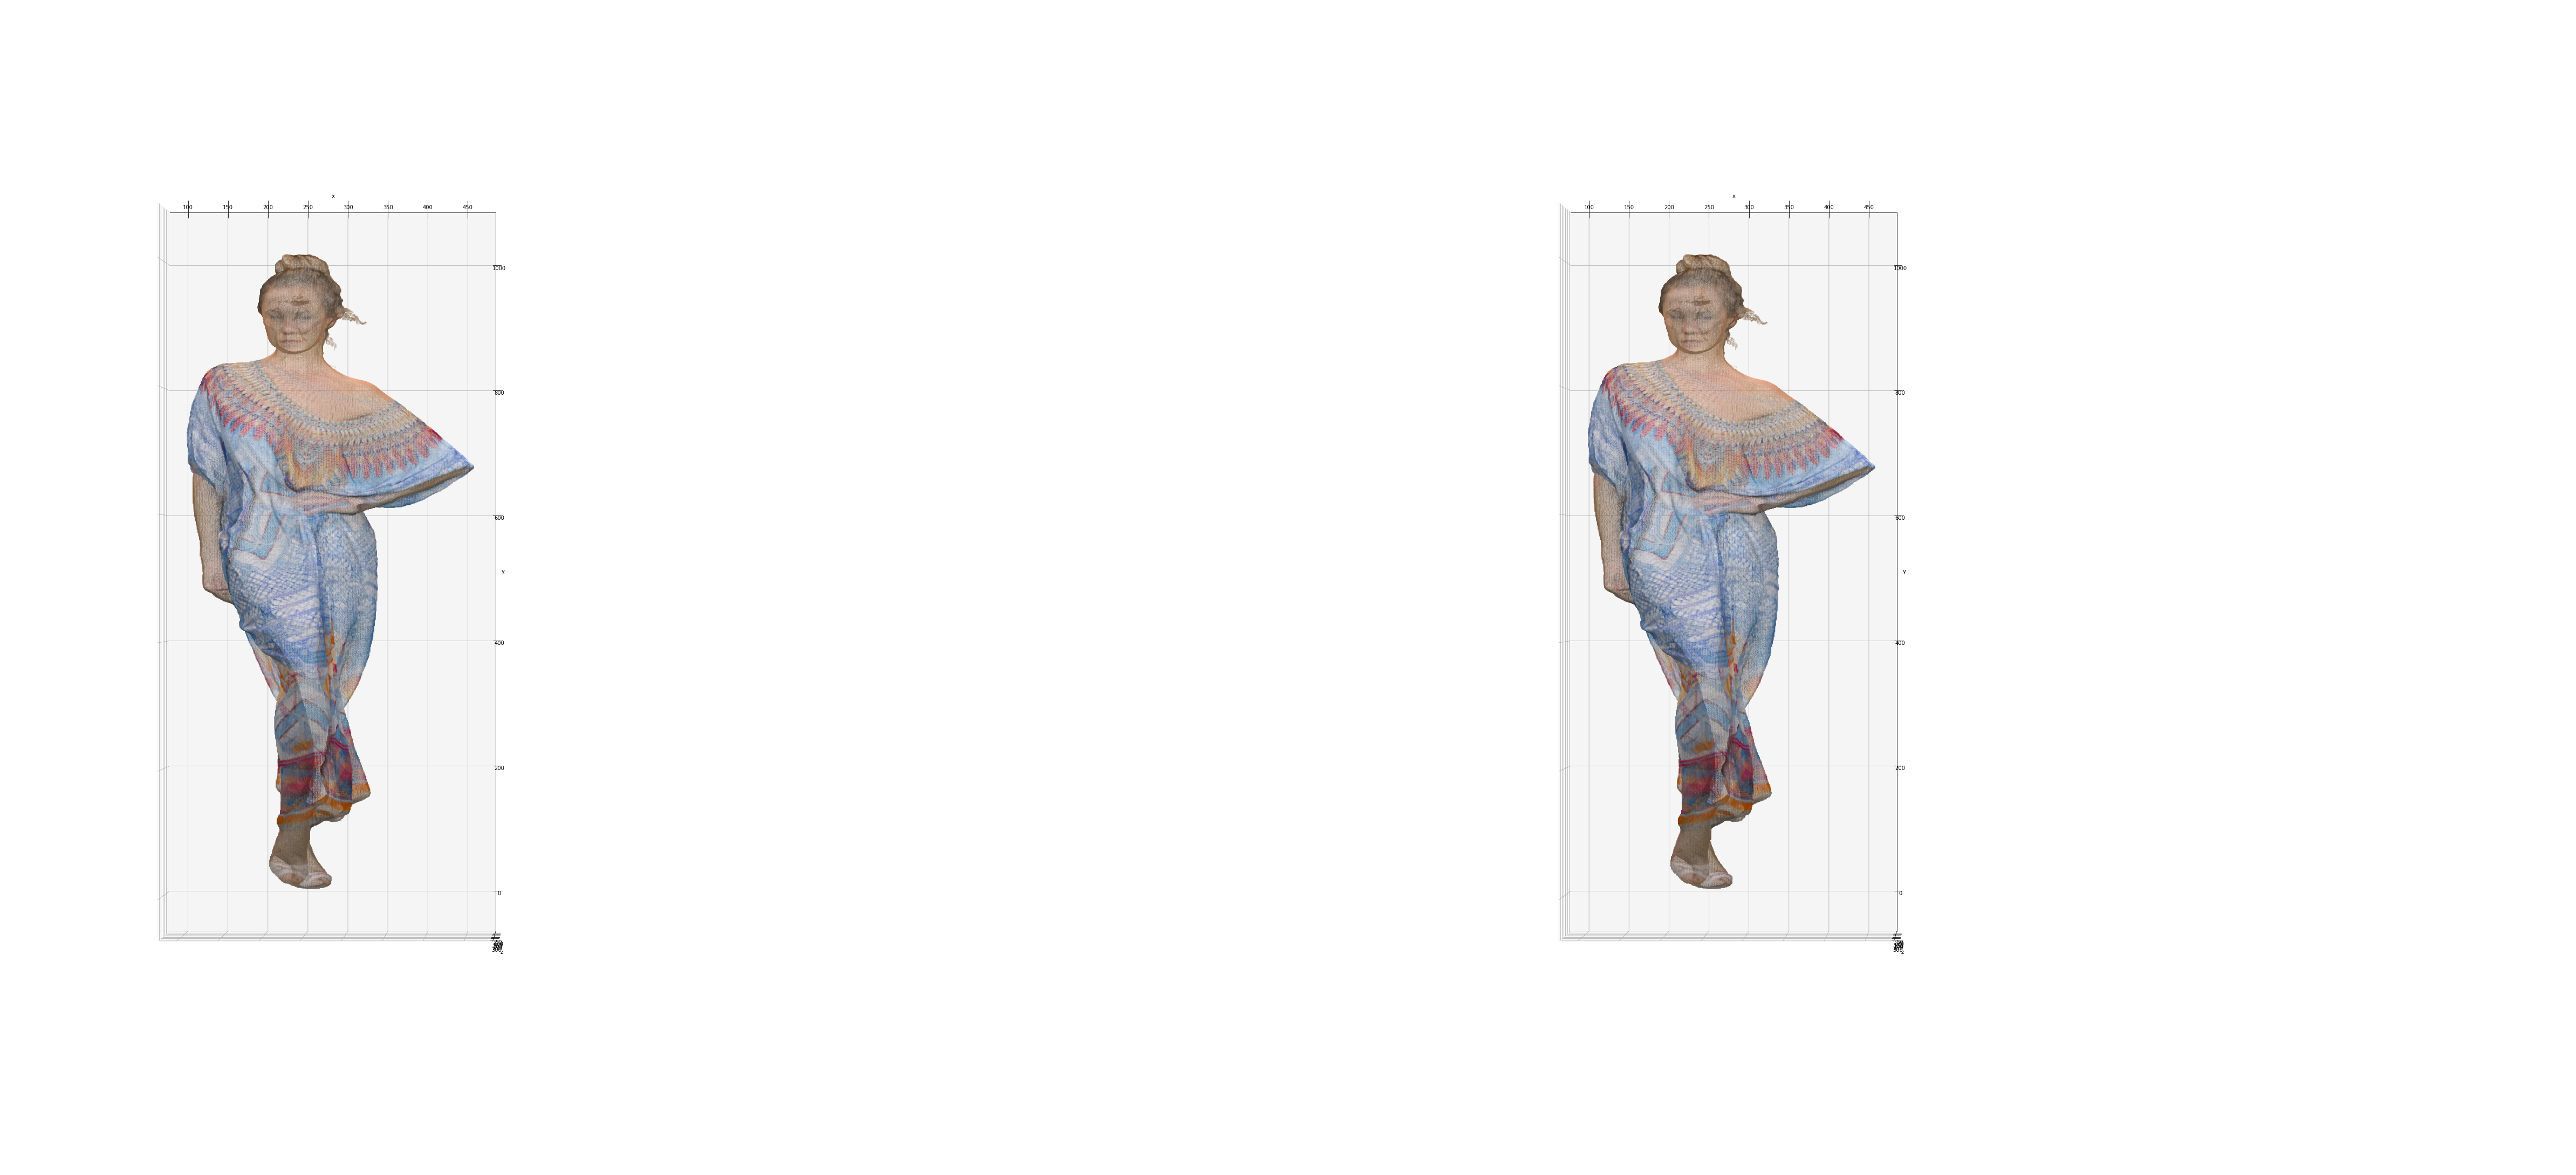

In [ ]:
cm = 1/2.54
fig = plt.figure(figsize=(120 * cm, 60 * cm))
# fig.subplots_adjust(bottom=-0.15,top=1.2, left=0.1, right=0.1)
fig.subplots_adjust(bottom=-0.2,top=1.2, left=-0.2, right=1.2)
ax = fig.add_subplot(121, projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.set_title('Sample Point Cloud')



ax.get_proj=get_subplot_proj(ax)
ax.scatter(pos[:,0],   # x
           pos[:,1],   # y
           pos[:,2],   # z
           facecolors=color/255., s=0.1# height data for color
          )
ax.view_init(90, -90)
ax = fig.add_subplot(122, projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


ax.get_proj=get_subplot_proj(ax)
ax.scatter(pos[:,0],   # x
           pos[:,1],   # y
           pos[:,2],   # z
           facecolors=color/255., s=0.1# height data for color
          )
ax.view_init(90, -90)
plt.show()
fig.savefig('test.png', dpi=300)